In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from typing import Tuple
import matplotlib as mpl


from ndgsp.graph.graphs import Graph
from ndgsp.graph.filters import MultivariateFilterFunction

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

import sys
sys.path.append('..')

import scipy as sp
import os

from PIL import Image

from tqdm.notebook import tqdm
import time

%matplotlib ipympl

In [51]:
N = 50
T = 50

Y, S, LN, LT = get_data(N, T)

g_ = lambda lamN, lamT: g(lamN, lamT, 0.5, 0.5)


In [59]:
y1, _ = SIM(Y, S, LN, LT, 1, g_)

In [65]:
y2, _ = CGM(Y, S, LN, LT, 1, g_)

In [54]:
y3 = direct(Y, S, LN, LT, 1, g_)

In [66]:
((y3 - y2) ** 2).sum()

2.7180183718886933e-09

In [57]:
((y3 - y2) ** 2).sum()

NameError: name 'y2' is not defined

In [74]:
def vec(X):
    return X.T.reshape(-1)


def mat(x, shape):
    return x.reshape((shape[1], shape[0])).T


def path_graph(N: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get the adjacency matrix and Laplacian for a path graph

    Params:
        N       The number of nodes

    Returns:
        A       (N, N) adjacency matrix        
        L       (N, N) Laplacian matrix
    """

    A = np.zeros((N, N))
    A[range(N-1), range(1, N)] = 1
    A += A.T

    L = np.diag(A.sum(0)) - A

    return A, L


def g(lamN: float | np.ndarray, 
      lamT: float | np.ndarray, 
      betaN: float, 
      betaT: float) -> float | np.ndarray:
    """
    An example anisotropic diffusion graph filter function

    Params:
        lamN                space eigenvalue
        lamT                time eigenvalue
        betaN               space filter parameter
        betaT               time filter parameter 

    Returns:
        g(λn, λt, βn, βt)   filter applied to eigenvalues
    """
    return np.exp(-(betaN * lamN + betaT * lamT))



def Uy(y):
    """
    Apply DCT matrix U to column vector y
    """
    return sp.fft.idct(y.T, type=2, norm='ortho').T

def UTy(y):
    """
    Apply IDCT matrix U.T to column vector y
    """
    return sp.fft.dct(y.T, type=2, norm='ortho').T

def yU(y):
    """
    Apply row vector y to DCT matrix U
    """
    return sp.fft.dct(y, type=2, norm='ortho')

def yUT(y):
    """
    Apply row vector y to IDCT matrix U.T
    """
    return sp.fft.idct(y, type=2, norm='ortho')


def direct(Y: np.ndarray, 
           S: np.ndarray, 
           LN: np.ndarray, 
           LT: np.ndarray, 
           gamma: float, 
           g: Callable) -> np.ndarray:
    
    """
    Compute the posterior mean using direct Gaussian elimination
    """

    N, T = Y.shape

    lamN, UN = np.linalg.eigh(LN)
    lamT, UT = np.linalg.eigh(LT)

    G = g(lamN[:, None], lamT[None, :])
    Hi2 = np.kron(UT, UN) @ np.diag(vec(G ** -2)) @ np.kron(UT.T, UN.T)

    return mat(np.linalg.solve(gamma * Hi2 + np.diag(vec(S)), vec(Y)), Y.shape)



def SIM(Y: np.ndarray, 
        S: np.ndarray, 
        LN: np.ndarray, 
        LT: np.ndarray, 
        gamma: float, 
        g: Callable) -> Tuple[np.ndarray, int]:
    
    """
    Perform the Stationary Iterative Method for computing the posterior mean

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        LN          (N, N) space-like Laplacian matrix
        LT          (T, T) time-like Laplacian matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """

    # edit this to set the maximum number of iterations
    MAX_ITERS = 1e7

    N, T = Y.shape

    lamN, UN = np.linalg.eigh(LN)
    lamT, UT = np.linalg.eigh(LT)

    G2 = g(lamN[:, None], lamT[None, :]) ** 2

    J = G2 / (G2 + gamma)

    S_ = 1 - S

    dF = UN @ (J * (UN.T @ Y @ UT)) @ UT.T

    F = dF

    nits = 0

    while (dF ** 2).sum() ** 0.5 / (N * T) > 1e-8:

        dF = UN @ (J * (UN.T @ (S_ * dF) @ UT)) @ UT.T

        F += dF

        nits += 1

        if nits == MAX_ITERS:
            print(f'Warning: Maximum iterations ({MAX_ITERS}) reached')
            break

    return F, nits


def SIM_TV(Y: np.ndarray, 
           S: np.ndarray, 
           LN: np.ndarray, 
           gamma: float, 
           g: Callable) -> Tuple[np.ndarray, int]:
    
    """
    Perform the Stationary Iterative Method for computing the posterior mean, where 
    the time like graph is a path graph, i.e. we have a time-vertex problem. Use the 
    DCT to speed up where possible. 

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        LN          (N, N) space-like Laplacian matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """

    # edit this to set the maximum number of iterations
    MAX_ITERS = 1e7

    N, T = Y.shape

    lamN, UN = np.linalg.eigh(LN)
    lamT = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))

    G2 = g(lamN[:, None], lamT[None, :]) ** 2

    J = G2 / (G2 + gamma)

    S_ = 1 - S

    dF = yUT(UN @ (J * (UN.T @ yU(Y))))

    F = dF

    nits = 0

    while (dF ** 2).sum() ** 0.5 / (N * T) > 1e-8:

        dF = yUT(UN @ (J * (UN.T @ yU(S_ * dF))))
        
        F += dF

        nits += 1

        if nits == MAX_ITERS:
            print(f'Warning: Maximum iterations ({MAX_ITERS}) reached')
            break

    return F, nits


def SIM_grid(Y: np.ndarray, 
             S: np.ndarray, 
             gamma: float, 
             g: Callable) -> Tuple[np.ndarray, int]:
    
    """
    Perform the Stationary Iterative Method for computing the posterior mean, where 
    both the time-like and space-like graphs are a path graph, meaning we have 2D 
    grid data. Use the DCT to speed up where possible. 

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """

    # edit this to set the maximum number of iterations
    MAX_ITERS = 1e7

    N, T = Y.shape

    lamN = 2 - 2 * np.cos(N ** -1 * np.pi * np.arange(N))
    lamT = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))

    G2 = g(lamN[:, None], lamT[None, :]) ** 2

    J = G2 / (G2 + gamma)

    S_ = 1 - S

    dF = yUT(Uy((J * UTy(yU(Y)))))

    F = dF

    nits = 0

    while (dF ** 2).sum() ** 0.5 / (N * T) > 1e-8:

        dF = yUT(Uy((J * UTy(yU(S_ * dF)))))

        F += dF

        nits += 1

        if nits == MAX_ITERS:
            print(f'Warning: Maximum iterations ({MAX_ITERS}) reached')
            break

    return F, nits



def CGM(Y: np.ndarray, 
        S: np.ndarray, 
        LN: np.ndarray, 
        LT: np.ndarray, 
        gamma: float, 
        g: Callable) -> Tuple[np.ndarray, int]:
    """

    Use the conjugate gradient method to perform graph signal reconstruction

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        LN          (N, N) space-like Laplacian matrix
        LT          (T, T) time-like Laplacian matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """


    # edit this to set the maximum number of iterations
    MAX_ITERS = 1e7

    N, T = Y.shape

    lamN, UN = np.linalg.eigh(LN)
    lamT, UT = np.linalg.eigh(LT)

    Z = np.zeros_like(Y)

    G = g(lamN[:, None], lamT[None, :])

    R = G * (UN.T @ Y @ UT) - gamma * Z - G * (UN.T @ (S * (UN @ (G * Z) @ UT.T)) @ UT)

    D = R
    res_new = (R ** 2).sum()
    res0 = res_new

    nits = 0

    while res_new > (1e-5 ** 2 * res0):

        nits += 1

        Ad = gamma * D + G * (UN.T @ (S * (UN @ (G * D) @ UT.T)) @ UT)

        alpha = res_new / (D * Ad).sum()

        Z += alpha * D

        # periodically rescale
        if nits % 50 == 0:
            R = Y - gamma * Z - G * (UN.T @ (S * (UN @ (G * Z) @ UT.T)) @ UT)
            D = R

        else:
            R -= alpha * Ad

        res_old = res_new
        res_new = (R ** 2).sum()
        D = R + D * res_new / res_old

        if nits == MAX_ITERS:
            print(f'Warning: Maximum iterations ({MAX_ITERS}) reached')
            break

    return UN @ (G * Z) @ UT.T, nits


def CGM_TV(Y: np.ndarray, 
           S: np.ndarray, 
           LN: np.ndarray, 
           gamma: float, 
           g: Callable) -> Tuple[np.ndarray, int]:
    """

    Use the conjugate gradient method to perform graph signal reconstruction

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        LN          (N, N) space-like Laplacian matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """


    # edit this to set the maximum number of iterations
    MAX_ITERS = 1e7

    N, T = Y.shape

    lamN, UN = np.linalg.eigh(LN)
    lamT = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))

    Z = np.zeros_like(Y)

    G = g(lamN[:, None], lamT[None, :])

    R = G * yU(UN.T @ Y) - gamma * Z - G * (UN.T @ yU(S * (UN @ yUT(G * Z))))

    D = R
    res_new = (R ** 2).sum()
    res0 = res_new

    nits = 0

    while res_new > (1e-5 ** 2 * res0):

        nits += 1

        Ad = gamma * D + G * (UN.T @ yU(S * (UN @ yUT(G * D))))

        alpha = res_new / (D * Ad).sum()

        Z += alpha * D

        # periodically rescale
        if nits % 50 == 0:
            R = Y - gamma * Z - G * (UN.T @ yU(S * (UN @ yUT(G * Z))))
            D = R

        else:
            R -= alpha * Ad

        res_old = res_new
        res_new = (R ** 2).sum()
        D = R + D * res_new / res_old

        if nits == MAX_ITERS:
            print(f'Warning: Maximum iterations ({MAX_ITERS}) reached')
            break

    return UN @ yUT(G * Z), nits


def CGM_grid(Y: np.ndarray, 
             S: np.ndarray, 
             gamma: float, 
             g: Callable) -> Tuple[np.ndarray, int]:
    """

    Use the conjugate gradient method to perform graph signal reconstruction

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """

    # edit this to set the maximum number of iterations
    MAX_ITERS = 1e7

    N, T = Y.shape

    lamN = 2 - 2 * np.cos(N ** -1 * np.pi * np.arange(N))
    lamT = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))

    Z = np.zeros_like(Y)

    G = g(lamN[:, None], lamT[None, :])

    R = G * yU(UTy(Y)) - gamma * Z - G * UTy(yU(S * Uy(yUT(G * Z))))

    D = R
    res_new = (R ** 2).sum()
    res0 = res_new

    nits = 0

    while res_new > (1e-5 ** 2 * res0):

        nits += 1

        Ad = gamma * D + G * UTy(yU(S * Uy(yUT(G * D))))

        alpha = res_new / (D * Ad).sum()

        Z += alpha * D

        # periodically rescale
        if nits % 50 == 0:
            R = Y - gamma * Z - G * UTy(yU(S * Uy(yUT(G * Z))))
            D = R

        else:
            R -= alpha * Ad

        res_old = res_new
        res_new = (R ** 2).sum()
        D = R + D * res_new / res_old

        if nits == MAX_ITERS:
            print(f'Warning: Maximum iterations ({MAX_ITERS}) reached')
            break

    return Uy(yUT(G * Z)), nits







In [78]:
from scipy.sparse.linalg import LinearOperator, cg

In [91]:

def CGM2(Y: np.ndarray, 
         S: np.ndarray, 
         LN: np.ndarray, 
         LT: np.ndarray, 
         gamma: float, 
         g: Callable) -> Tuple[np.ndarray, int]:
    
    N, T = Y.shape

    lamT, UT = np.linalg.eigh(LN)
    lamN, UN = np.linalg.eigh(LT)

    G = g(lamN[:, None], lamT[None, :])

    def matvec(z):

        Z = mat(z, (N, T))

        out = gamma * Z + G * (UN.T @ (S * (UN @ (G * Z) @ UT.T)) @ UT)

        return vec(out)
    
    nits = 0

    def nonlocal_iterate(arr):
        nonlocal nits
        nits += 1
    
    linop = LinearOperator((N * T, N * T), matvec=matvec)
    
    z, exit_code = cg(linop, vec(G * (UN.T @ Y @ UT)), callback=nonlocal_iterate)

    return UN @ (G * mat(z, (N, T))) @ UT.T, nits
 



In [92]:
g_ = lambda lamN, lamT: g(lamN, lamT, 0.5, 0.5)
gamma = 1
Y, S, LN, LT = get_data(50, 50)


F, its = CGM2(Y, S, LN, LT, gamma, g_)

In [93]:
its

6

In [84]:
SIM(Y, S, LN, LT, gamma, g_)

(array([[ 0.078,  0.145,  0.252,  0.412,  0.378, ..., -0.05 , -0.011, -0.043, -0.167, -0.159],
        [ 0.066,  0.107,  0.146,  0.233,  0.234, ...,  0.045,  0.076,  0.043, -0.074, -0.078],
        [ 0.091,  0.131,  0.141,  0.167,  0.156, ...,  0.108,  0.111,  0.046, -0.052, -0.038],
        [ 0.126,  0.18 ,  0.188,  0.159,  0.084, ...,  0.108,  0.106,  0.032, -0.051, -0.038],
        [ 0.066,  0.128,  0.18 ,  0.162,  0.066, ...,  0.095,  0.089,  0.017, -0.08 , -0.111],
        ...,
        [ 0.   ,  0.071,  0.1  ,  0.075,  0.037, ...,  0.029,  0.048, -0.011, -0.104, -0.102],
        [ 0.001,  0.029,  0.041, -0.005, -0.029, ...,  0.066,  0.105,  0.073, -0.031, -0.064],
        [ 0.05 ,  0.017, -0.003, -0.08 , -0.099, ...,  0.075,  0.093,  0.07 , -0.01 , -0.04 ],
        [ 0.23 ,  0.132,  0.071, -0.021, -0.059, ...,  0.13 ,  0.1  ,  0.047, -0.009, -0.023],
        [ 0.466,  0.298,  0.182,  0.056, -0.024, ...,  0.21 ,  0.126,  0.042, -0.005, -0.012]]),
 11)

In [4]:
def verify_SIM_CGM():
    """
    Verify that the SIM and CGM give the correct answer to the linear system
    """

    np.random.seed(0)

    betaN = 0.5
    betaT = 0.5
    gamma = 1

    N = 10
    T = 12

    AN, LN = path_graph(N)
    AT, LT = path_graph(T)

    Y = np.random.normal(size=(N, T))
    S = np.random.randint(2, size=(N, T)).astype(float)
    Y *= S

    g_ = lambda lamN, lamT: g(lamN, lamT, betaN, betaT)

    # calculate the solution directly  (this is only stable for relatively small values of beta)
    F_dir = direct(Y, S, LN, LT, gamma, g_)

    # calculate the solution using the SIM 
    F_sim1, _ = SIM(Y, S, LN, LT, gamma, g_)
    F_sim2, _ = SIM_TV(Y, S, LN, gamma, g_)
    F_sim3, _ = SIM_grid(Y, S, gamma, g_)

    # calculate the solution using the CGM
    F_cgm1, _ = CGM(Y, S, LN, LT, gamma, g_)
    F_cgm2, _ = CGM_TV(Y, S, LN, gamma, g_)
    F_cgm3, _ = CGM_grid(Y, S, gamma, g_)

    for Y_ in [F_sim1, F_sim2, F_sim3, F_cgm1, F_cgm2, F_cgm3]:
        assert np.allclose(F_dir, Y_, rtol=1e-4, atol=1e-4), f'{F_dir}, {Y_}'

    return True




In [5]:
verify_SIM_CGM()

True

In [10]:
def get_Y_and_S_uniform(Y_true, SNR=0, p=0.5, seed=0):
    """
    Given a true underlying image, add noise with a given SNR and remove pixels 
    uniformly at random with probability p
    """

    np.random.seed(seed)
    
    sig_y = 10 ** (-SNR / 20)
    Y = Y_true + sig_y * np.random.randn(*Y_true.shape)
    S = np.random.choice(2, size=Y_true.shape, p=[1-p, p]).astype(bool)
    
    Y[S] = 0
    Y_nan = Y.copy()
    Y_nan[S] = np.nan
    
    return Y_nan, Y, S


def get_Y_and_S_rowcol(Y_true, SNR=0, p=0.5, seed=1):
    """
    Given a true underlying image, add noise with a given SNR and remove columns
    and rows of pixels a random such that a total of p% of the pixels are removed
    """
        
    np.random.seed(seed)

    N, T = Y_true.shape

    sig_y = 10 ** (-SNR / 20)
    Y = Y_true + sig_y * np.random.randn(*Y_true.shape)
    
    S = np.ones(Y_true.shape, dtype=bool)
    S[np.random.choice(range(N), size= int(N * (1 - (1-p) ** 0.5)), replace=False), :] = False
    S[:, np.random.choice(range(T), size= int(T * (1 - (1-p) ** 0.5)), replace=False)] = False
        
    Y[~S] = 0
    Y_nan = Y.copy()
    Y_nan[~S] = np.nan
    
    return Y_nan, Y, S

In [6]:
def plot_uniform_pixels(Y_true: np.ndarray):
    """
    Create a plot showing the reconstruction process over a range of noise
    and missingness levels for uniformly removed pixels
    """

    fig1, axes1 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))
    fig2, axes2 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))

    for i, snr in enumerate([10, 0, -10]):
        
        for j, p in enumerate([0.01, 0.1, 0.25, 0.5]):
            
            gamma = [1, 0.85, 0.75, 0.2][j]
        
            Y_nan, Y, S = get_Y_and_S_uniform(Y_true, SNR=snr, p=p)
            
            F, _ =  CGM_grid(Y, S, gamma, lambda lamN, lamT: g(lamN, lamT, 2, 2))
            
            axes1[i, j].imshow(Y_nan,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')
            axes2[i, j].imshow(F,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')

            for ax in [axes1[i, j], axes2[i, j]]:
                
                ax.set_xticks([])
                ax.set_yticks([])
            
    for ax, title in zip(axes1[0, :], ['$p=0.01$', '$p=0.1$', '$p=0.25$', '$p=0.5$']):
        ax.set_title(title, size='xx-large', )

    for ax, title in zip(axes1[:, 0], [r'SNR = 10 dB', 'SNR = 0 dB', 'SNR = -10 dB']):
        ax.set_ylabel(title,  size='x-large', labelpad=5)

    for ax, title in zip(axes2[:, 0], [r'SNR = 10 dB', 'SNR = 0 dB', 'SNR = -10 dB']):
        ax.set_ylabel(title,  size='x-large', labelpad=5)
        
    fig1.tight_layout()
    fig2.tight_layout()

    return fig1, fig2


In [7]:
def plot_rowcol_pixels(Y_true: np.ndarray):
    """
    Create a plot showing the reconstruction process over a range of noise
    and missingness levels for entire columns and rows of pixels removed
    """

    fig1, axes1 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))
    fig2, axes2 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))

    for i, snr in enumerate([10, 0, -10]):
        
        for j, p in enumerate([0.01, 0.1, 0.25, 0.5]):
            
            gamma = [0.2, 0.2, 0.2, 0.1][j]
        
            Y_nan, Y, S = get_Y_and_S_rowcol(Y_true, SNR=snr, p=p)
            
            F, _ =  CGM_grid(Y, S, gamma, lambda lamN, lamT: g(lamN, lamT, 2, 2))
            
            axes1[i, j].imshow(Y_nan,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')
            axes2[i, j].imshow(F,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')

            for ax in [axes1[i, j], axes2[i, j]]:
                
                ax.set_xticks([])
                ax.set_yticks([])
            
    for ax, title in zip(axes1[0, :], ['$p=0.01$', '$p=0.1$', '$p=0.25$', '$p=0.5$']):
        ax.set_title(title, size='xx-large', )

    fig1.tight_layout()
    fig2.tight_layout()

    return fig1, fig2


In [8]:
def make_super_plot():

    im = Image.open('data/butterfly1.jpg')
    im.thumbnail((856, 856))

    Y_true = np.array(im).mean(-1)
    Y_true = (Y_true - Y_true.mean()) / Y_true.std()
    N, T = Y_true.shape

    fig00, fig01 = plot_uniform_pixels(Y_true)
    fig10, fig11 = plot_rowcol_pixels(Y_true)

    fig00.savefig('data/inputs1.jpg')
    fig01.savefig('data/outputs1.jpg')

    fig10.savefig('data/inputs2.jpg')
    fig11.savefig('data/outputs2.jpg')

    im00 = Image.open('data/inputs1.jpg')
    im01 = Image.open('data/inputs2.jpg')
    im10 = Image.open('data/outputs1.jpg')
    im11 = Image.open('data/outputs2.jpg')

    im = Image.new("RGB", (2030, 1100), "white")

    im.paste(im00, (0, 0))
    im.paste(im01, (1015, 0))
    im.paste(im10, (0, 550))
    im.paste(im11, (1015, 550))

    im.save('data/butterfly_plot.jpg')

    os.remove('data/inputs1.jpg')
    os.remove('data/outputs1.jpg')    
    os.remove('data/inputs2.jpg')    
    os.remove('data/outputs2.jpg')

    return im

In [11]:
%%capture 
im = make_super_plot()


In [6]:
def get_data(N: int, T: int, seed=0):
    
    np.random.seed(seed)
    Y = np.random.normal(size=(N, T))
    S = np.random.randint(0, 2, size=(N, T)).astype(bool)
    Y[S] = 0
    
    AN, LN = path_graph(N)
    AT, LT = path_graph(T)

    return Y, S, LN, LT

In [7]:
nts = np.sort(np.array(list(set(np.sort(np.concatenate([np.logspace(1, 4).astype(int), np.linspace(1e1, 1e4).astype(int)])).tolist()))))


def get_ts():

    ts = [[], [], [], [], []]

    active = [True, True, True, True, True]

    g_ = lambda lamN, lamT: g(lamN, lamT, 0.5, 0.5)
    gamma = 1

    for nt in tqdm(nts):

        print(nt)

        if not any(active):
            break

        Y, S, LN, LT = get_data(nt, nt)

        all_args = [(Y, S, LN, LT, gamma, g_), (Y, S, LN, LT, gamma, g_), (Y, S, LN, LT, gamma, g_), (Y, S, gamma, g_), (Y, S, gamma, g_)]

        for i, (solver, args) in enumerate(zip([direct, SIM, CGM, SIM_grid, CGM_grid], all_args)):

            if active[i]:

                t0 = time.time()
                solver(*args)
                t = time.time() - t0

                ts[i].append(t)
            
                if t > 60:
                    active[i] = False

    return ts

In [8]:
ts = get_ts()

  0%|          | 0/97 [00:00<?, ?it/s]

10
11
13
15
17
20
23
26
30
35
40
47
54
62
71
82
95
109
126
145
167
193
213
222
255
294
339
390
417
449
517
596
621
686
790
825
910
1029
1048
1206
1233
1389
1437
1599
1641
1842
1844
2048
2120
2252
2442
2456
2660
2811
2864
3068
3237
3272
3475
3679
3727
3883
4087
4291
4495
4699
4903
4941
5106
5310
5514
5689
5718
5922
6126
6330


/tmp/ipykernel_501540/2418779750.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figf, ax = plt.subplots(ncols=2, figsize=(10, 5))


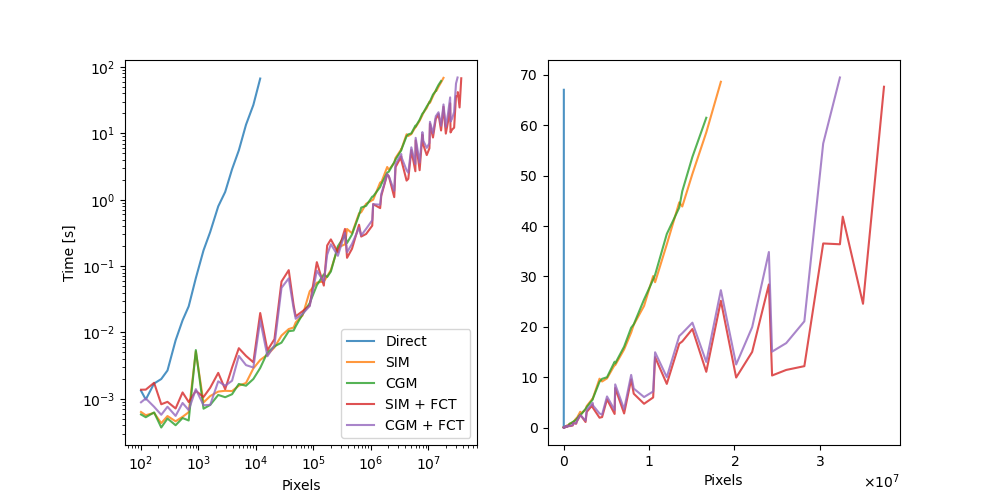

In [33]:


figf, ax = plt.subplots(ncols=2, figsize=(10, 5))

for t, label in zip(ts, ['Direct', 'SIM', 'CGM', 'SIM + FCT', 'CGM + FCT']):

    ax[0].plot(nts[:len(t)] ** 2, t, label=label, alpha=0.8)
    ax[1].plot(nts[:len(t)] ** 2, t, label=label, alpha=0.8)

ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_xlabel('Pixels')
ax[1].set_xlabel('Pixels')
ax[0].set_ylabel('Time [s]')

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)

ax[0].legend()

plt.savefig('SIM_CGM_time.pdf')

In [96]:
gammas = np.logspace(-4, 1)

its_sim = []
its_cgm = []

Y, S, LN, LT = get_data(50, 50)

g_ = lambda lamN, lamT: g(lamN, lamT, 0.5, 0.5)

for gamma in tqdm(list(reversed(gammas))):

    F_sim, it_sim = SIM(Y, S, LN, LT, gamma, g_)
    F_cgm, it_cgm = CGM2(Y, S, LN, LT, gamma, g_)

    its_sim.append(it_sim)
    its_cgm.append(it_cgm)

  0%|          | 0/50 [00:00<?, ?it/s]

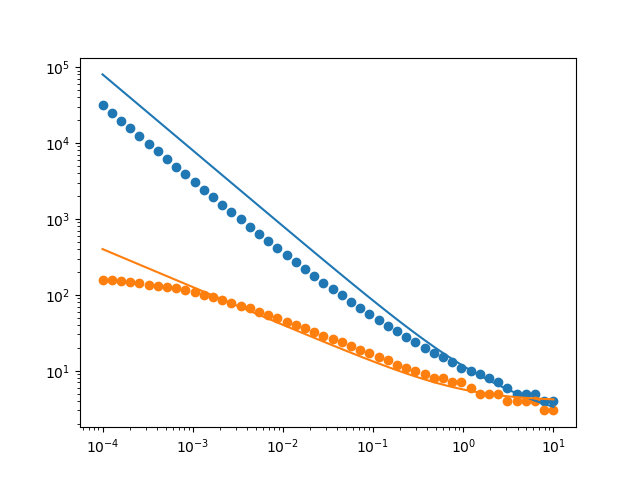

In [97]:
plt.figure()

plt.scatter(gammas, list(reversed(its_sim)))
plt.scatter(gammas, list(reversed(its_cgm)))

plt.plot(gammas, 8 / np.log(1 + gammas))
plt.plot(gammas, 4 * ((1 + gammas) / gammas) ** 0.5)


plt.xscale('log')
plt.yscale('log')